In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GroupKFold, StratifiedKFold, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.feature_selection import RFE, SelectFromModel
from xgboost import XGBClassifier, plot_importance
from IPython import display
from datetime import datetime
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
from matplotlib import cm

from pylab import rcParams

import os
import re
import time

seed = 9001
np.random.seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load the non-temporal processed data

In [4]:
X = pd.read_csv('non_temporal_processed.csv')

/content/drive/My Drive/sepsis


In [0]:
signals = ['HR', 'MAP', 'O2Sat', 'SBP', 'Resp', 'DBP', 'Temp', 'id'] # include 'id' to perform groupby

In [0]:
demographics = [var for var in X if var not in signals]

In [0]:
demographics

['SepsisLabel', 'Gender', 'Age', 'hour', 'HospAdmTime']

## Use temporal effect with rolling window of 6 data points

### Mean rolling windows

In [0]:
X_mean = X[signals].groupby('id').rolling(window=6).mean()

In [0]:
X_mean = X_mean.drop(columns='id')

In [0]:
X_mean.columns += '_mean'

### Standard deviation rolling windows

In [0]:
X_std = X[signals].groupby('id').rolling(window=6).std()

In [0]:
X_std = X_std.drop(columns='id')

In [0]:
X_std.columns += '_std'

### Minimum value rolling windows

In [0]:
X_min = X[signals].groupby('id').rolling(window=6).min()

In [0]:
X_min = X_min.drop(columns='id')

In [0]:
X_min.columns += '_min'

### Maximum value rolling windows

In [0]:
X_max = X[signals].groupby('id').rolling(window=6).max()

In [0]:
X_max = X_max.drop(columns='id')

In [0]:
X_max.columns += '_max'

### Difference between 6th hour and 5th hour

In [0]:
# custom function to calculate difference betwen 6th and 5th hours

def diff1(x):
    return x[-1] - x[-2]

In [0]:
X_diff1 = X[signals].groupby('id').rolling(window=6).apply(diff1, raw=True)

In [0]:
X_diff1 = X_diff1.drop(columns='id')

In [0]:
X_diff1.columns += '_diff1'

### Difference between 5th hour and 4th hour

In [0]:
# custom function to calculate difference between 5th and 4th hours

def diff2(x):
    return x[-2] - x[-3]

In [0]:
X_diff2 = X[signals].groupby('id').rolling(window=6).apply(diff2, raw=True)

In [0]:
X_diff2 = X_diff2.drop(columns='id')

In [0]:
X_diff2.columns += '_diff2'

### Difference between 4th hour and 3rd hour

In [0]:
# custom function to calculate difference between 4th and 3rd hours

def diff3(x):
    return x[-3] - x[-4]

In [0]:
X_diff3 = X[signals].groupby('id').rolling(window=6).apply(diff3, raw=True)

In [0]:
X_diff3 = X_diff3.drop(columns='id')

In [0]:
X_diff3.columns += '_diff3'

### Difference between 3rd hour and 2nd hour

In [0]:
# custom function to calculate difference between 3rd and 2nd hours

def diff4(x):
    return x[-4] - x[-5]

In [0]:
X_diff4 = X[signals].groupby('id').rolling(window=6).apply(diff4, raw=True)

In [0]:
X_diff4 = X_diff4.drop(columns='id')

In [0]:
X_diff4.columns += '_diff4'

### Difference between 2nd hour and 1st hour

In [0]:
# custom function to calculate difference between 2nd and 1st hours

def diff5(x):
    return x[-5] - x[0]

In [0]:
X_diff5 = X[signals].groupby('id').rolling(window=6).apply(diff5, raw=True)

In [0]:
X_diff5 = X_diff5.drop(columns='id')

In [0]:
X_diff5.columns += '_diff5'

### Append all dataframes of the extracted statistics column-wise

In [0]:
df = pd.concat([X_mean, X_std, X_min, X_max, X_diff1, X_diff2, X_diff3, X_diff4, X_diff5], axis=1)

In [0]:
df = df.reset_index(drop=True) # drop the index 'id' 

In [0]:
df.shape

(1552210, 63)

### Append the demographics information to the combined dataframe

In [0]:
df = pd.concat([df, X[demographics]], axis=1)

In [0]:
df.shape

(1552210, 68)

### Now drop the NaN rows that were used to extract statistics because they are not needed anymore

In [0]:
# get the indices of the NaN rows to drop them in the label column

nan_ind = df.loc[df.isnull().any(1)].index

In [0]:
# drop rows that have at least 1 NaN in one of the columns

df = df.dropna()

In [0]:
# double check missing values again

missing = (df.isnull().sum() / df.shape[0]) * 100
missing

HR_mean        0.0
MAP_mean       0.0
O2Sat_mean     0.0
SBP_mean       0.0
Resp_mean      0.0
              ... 
SepsisLabel    0.0
Gender         0.0
Age            0.0
hour           0.0
HospAdmTime    0.0
Length: 68, dtype: float64

### No more missing values. Let's save this dataset so we can access later

In [0]:
df.to_csv('6hour_extracted.csv', index=False)

### Let's read in 6-hour processed data

In [0]:
df = pd.read_csv('6hour_extracted.csv')

In [0]:
df.head()

,HR_mean,MAP_mean,O2Sat_mean,SBP_mean,Resp_mean,DBP_mean,Temp_mean,HR_std,MAP_std,O2Sat_std,SBP_std,Resp_std,DBP_std,Temp_std,HR_min,MAP_min,O2Sat_min,SBP_min,Resp_min,DBP_min,Temp_min,HR_max,MAP_max,O2Sat_max,SBP_max,Resp_max,DBP_max,Temp_max,HR_diff1,MAP_diff1,O2Sat_diff1,SBP_diff1,Resp_diff1,DBP_diff1,Temp_diff1,HR_diff2,MAP_diff2,O2Sat_diff2,SBP_diff2,Resp_diff2,DBP_diff2,Temp_diff2,HR_diff3,MAP_diff3,O2Sat_diff3,SBP_diff3,Resp_diff3,DBP_diff3,Temp_diff3,HR_diff4,MAP_diff4,O2Sat_diff4,SBP_diff4,Resp_diff4,DBP_diff4,Temp_diff4,HR_diff5,MAP_diff5,O2Sat_diff5,SBP_diff5,Resp_diff5,DBP_diff5,Temp_diff5,SepsisLabel,Gender,Age,hour,HospAdmTime
0,97.666667,84.220000,93.916667,114.000000,22.750000,43.0,36.110000,7.941452,7.287046,3.666288,12.393547,4.120073,0.0,0.000000,89.0,75.33,88.5,98.0,19.0,43.0,36.11,110.0,91.33,99.0,122.0,30.0,43.0,36.11,7.0,0.00,2.5,0.0,-2.5,0.0,0.00,13.0,5.33,-6.5,0.0,-5.5,0.0,0.0,1.0,0.00,-4.0,0.0,8.0,0.0,0.0,-8.0,10.67,4.0,24.0,3.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,83.14,5,-0.03
1,99.500000,84.498333,93.416667,118.166667,24.416667,43.0,36.110000,8.961027,6.901256,3.693463,9.887703,4.317600,0.0,0.000000,89.0,75.33,88.5,98.0,19.0,43.0,36.11,110.0,91.33,99.0,123.0,30.0,43.0,36.11,-2.0,-14.33,1.0,1.0,7.0,0.0,0.00,7.0,0.00,2.5,0.0,-2.5,0.0,0.0,13.0,5.33,-6.5,0.0,-5.5,0.0,0.0,1.0,0.00,-4.0,0.0,8.0,0.0,0.0,-8.0,10.67,4.0,24.0,3.0,0.0,0.0,0,0,83.14,6,-0.03
2,101.000000,84.665000,92.666667,117.333333,26.083333,43.0,36.110000,9.208692,6.642791,3.763863,11.927559,3.693463,0.0,0.000000,89.0,76.33,88.5,93.0,22.0,43.0,36.11,110.0,91.33,99.0,123.0,30.0,43.0,36.11,-2.0,-0.67,-1.5,-30.0,0.0,0.0,0.00,-2.0,-14.33,1.0,1.0,7.0,0.0,0.0,7.0,0.00,2.5,0.0,-2.5,0.0,0.0,13.0,5.33,-6.5,0.0,-5.5,0.0,0.0,1.0,0.00,-4.0,0.0,8.0,0.0,0.0,0,0,83.14,7,-0.03
3,103.500000,85.053333,92.000000,119.166667,26.750000,43.0,36.110000,7.092249,6.802625,2.588436,13.526517,3.126500,0.0,0.000000,90.0,76.33,88.5,93.0,22.0,43.0,36.11,110.0,91.33,95.0,133.0,30.0,43.0,36.11,-2.0,12.00,4.5,40.0,-3.0,0.0,0.00,-2.0,-0.67,-1.5,-30.0,0.0,0.0,0.0,-2.0,-14.33,1.0,1.0,7.0,0.0,0.0,7.0,0.00,2.5,0.0,-2.5,0.0,0.0,13.0,5.33,-6.5,0.0,-5.5,0.0,0.0,0,0,83.14,8,-0.03
4,105.500000,85.275000,91.333333,121.166667,26.750000,43.0,36.286667,3.082207,6.861060,2.136976,14.851487,3.126500,0.0,0.432743,102.0,76.33,88.5,93.0,22.0,43.0,36.11,110.0,91.33,95.0,134.0,30.0,43.0,37.17,-2.0,-1.00,-4.0,1.0,4.0,0.0,1.06,-2.0,12.00,4.5,40.0,-3.0,0.0,0.0,-2.0,-0.67,-1.5,-30.0,0.0,0.0,0.0,-2.0,-14.33,1.0,1.0,7.0,0.0,0.0,7.0,0.00,2.5,0.0,-2.5,0.0,0.0,0,0,83.14,9,-0.03


### Stratified Data Partition (to preserve the classes proportion)

In [0]:
# data partition: 80/20 training, testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['SepsisLabel']) # stratified splitting to reserve the classes proportion

### Save the raw training and test splits before any pre-processing

In [0]:
train_df.to_csv('6hour_traindf.csv', index=False)
test_df.to_csv('6hour_testdf.csv', index=False)

### Note: we are now classifying sepsis based on patterns (extracted characteristics from windows, NOT by hourly measurements or by patients)

In [0]:
# check distribution of sepsis patterns in training set

print('Number of sepsis patterns: ', train_df['SepsisLabel'].value_counts()[1])
print('Number of non-sepsis patterns: ', train_df['SepsisLabel'].value_counts()[0])

distribution = (train_df['SepsisLabel'].value_counts()[1] / sum(train_df['SepsisLabel'].value_counts()))
print('Distribution of sepsis events: ', distribution*100, '%')

Number of sepsis patterns:  20109
Number of non-sepsis patterns:  1060315
Distribution of sepsis events:  1.8612137457146454 %


In [0]:
# check distribution of sepsis patterns in test set

print('Number of sepsis patterns: ', test_df['SepsisLabel'].value_counts()[1])
print('Number of non-sepsis patterns: ', test_df['SepsisLabel'].value_counts()[0])

distribution = (test_df['SepsisLabel'].value_counts()[1] / sum(test_df['SepsisLabel'].value_counts()))
print('Distribution of sepsis events: ', distribution*100, '%')

Number of sepsis patterns:  5027
Number of non-sepsis patterns:  265079
Distribution of sepsis events:  1.861121189458953 %


### Plot distribution of each feature

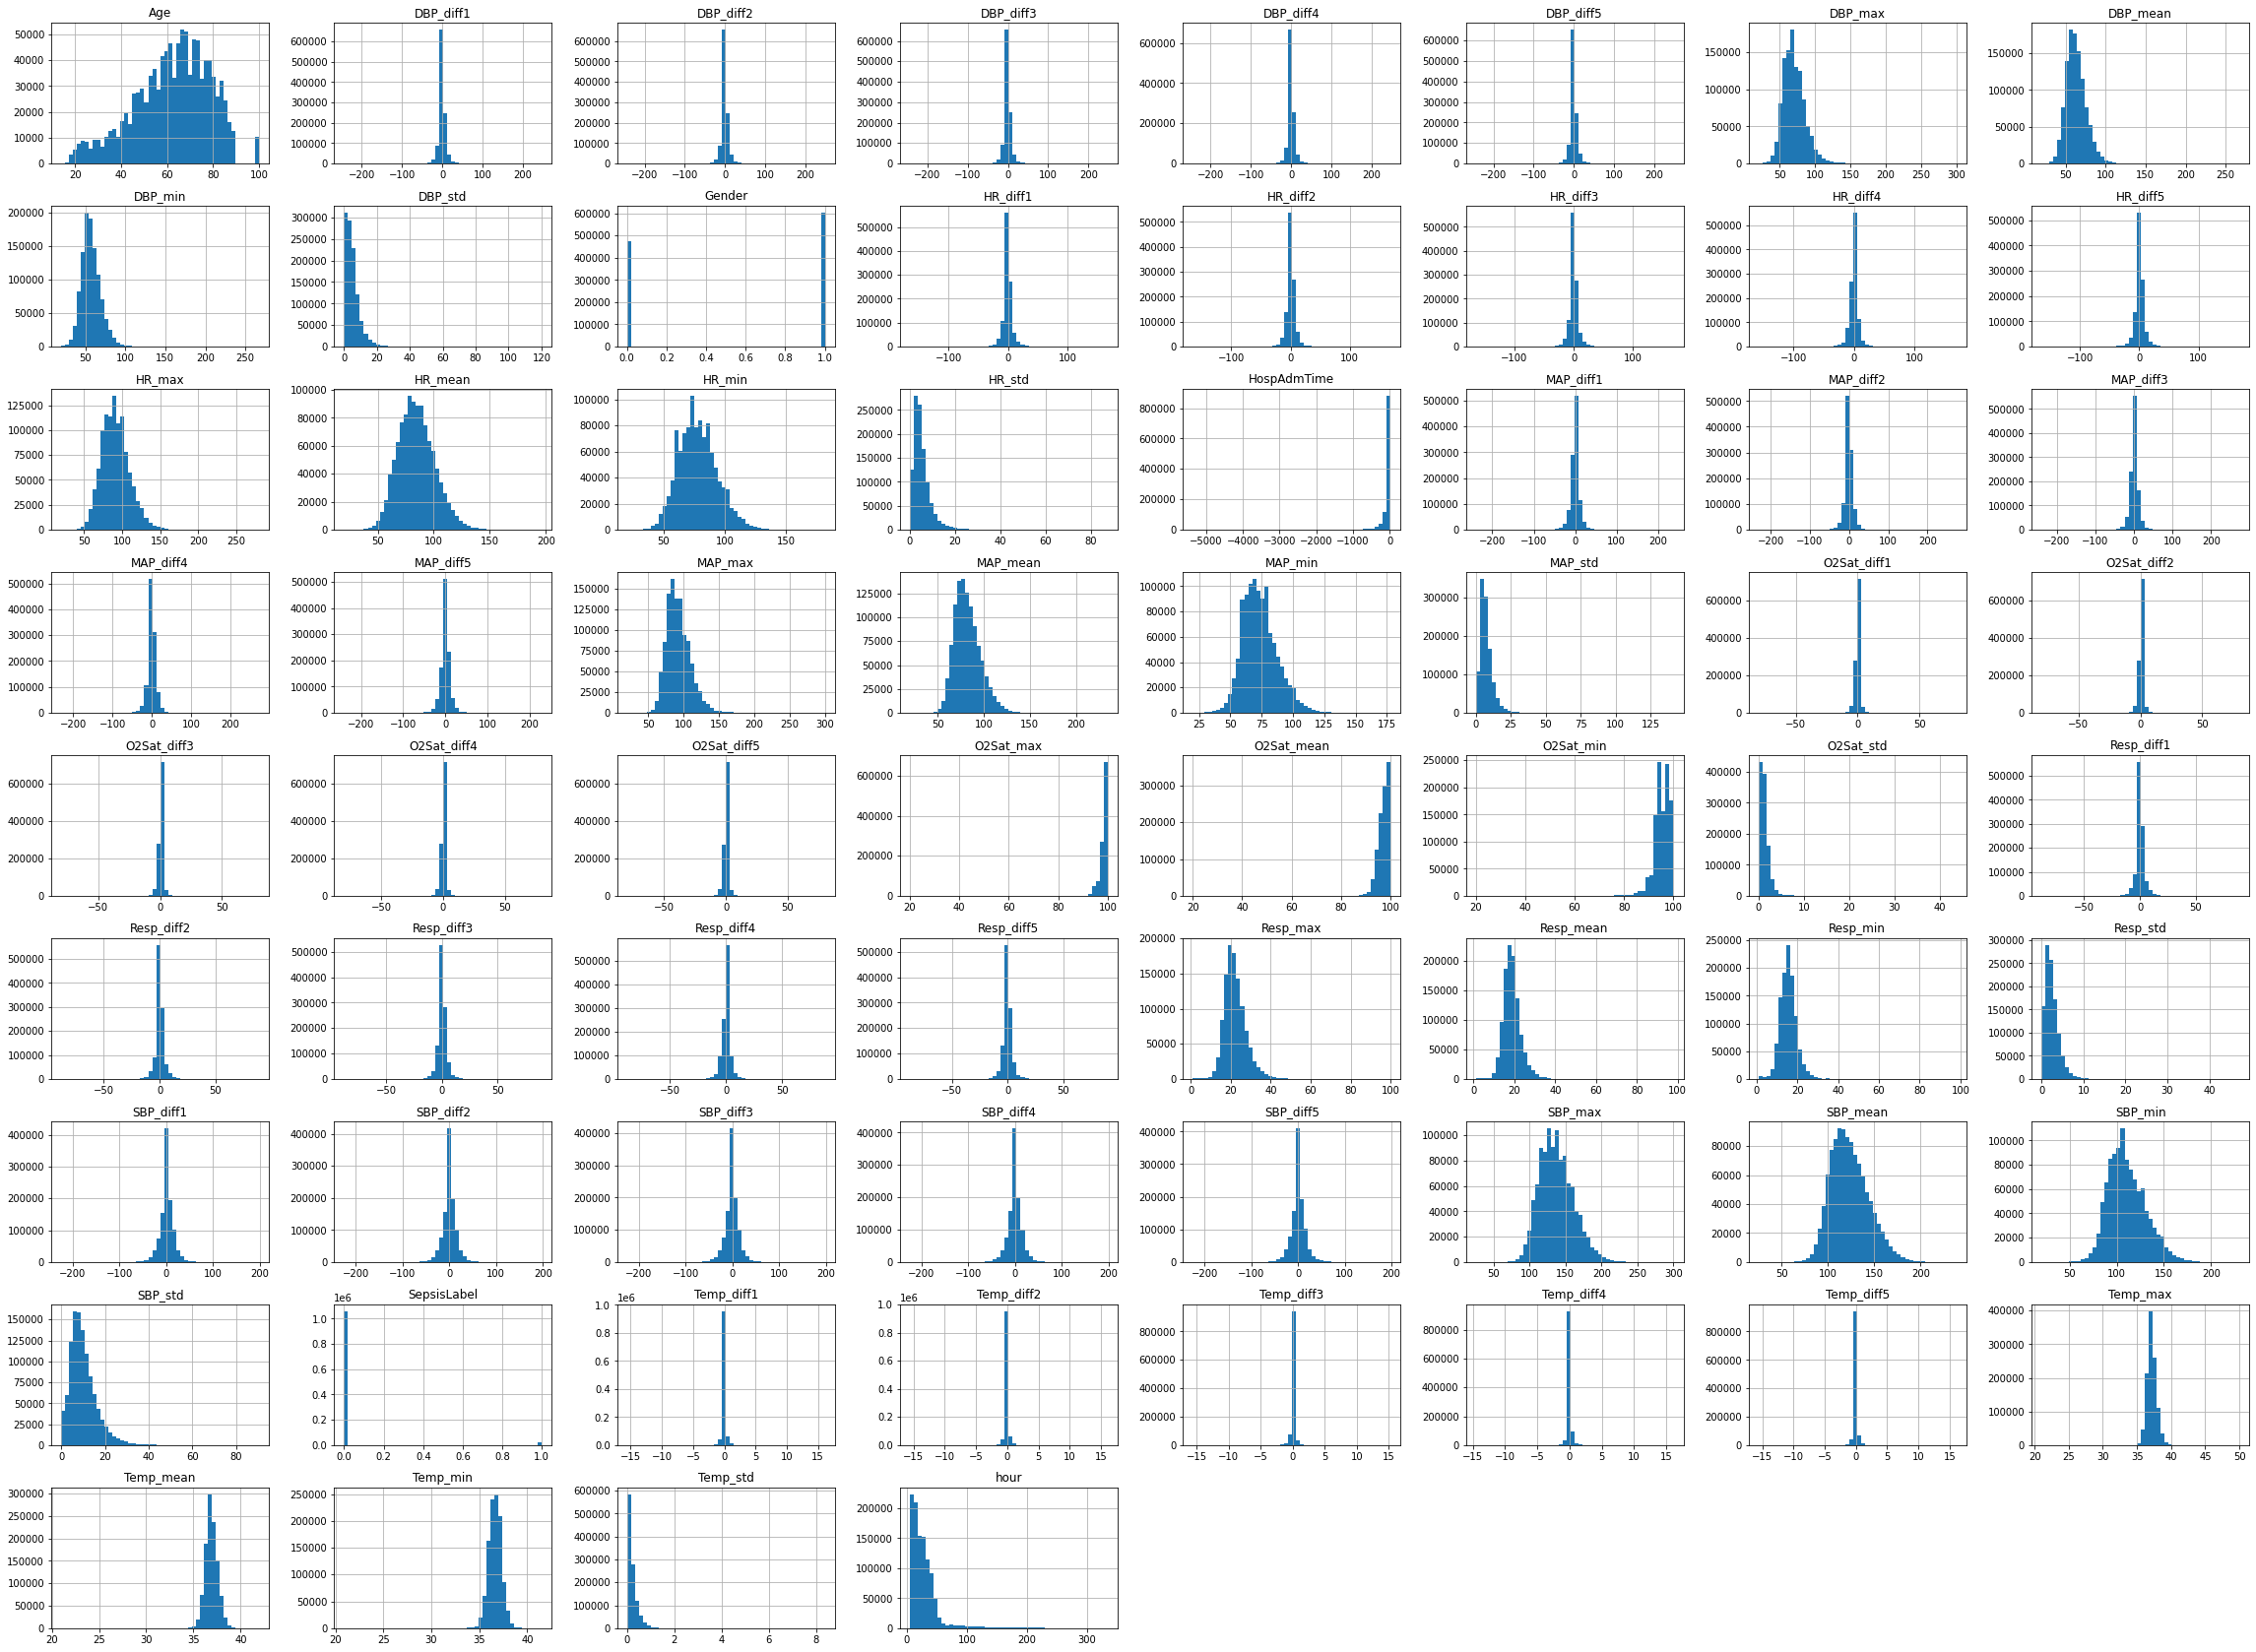

In [0]:
train_df.hist(bins=50, figsize=(40,30))
plt.show()

### Take a look at the distribution of extracted patterns between sepsis & non-sepsis events

In [0]:
import seaborn as sns
plt.rcParams.update({'figure.max_open_warning': 0})

cont_vars = [col for col in train_df.columns if col not in ['SepsisLabel', 'Gender', 'HospAdmTime', 'hour']]

In [0]:
train_df.loc[train_df['SepsisLabel'] == 1, 'HR_std'] = np.random.normal(loc=25, scale=25, size=train_df['SepsisLabel'].value_counts()[1])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


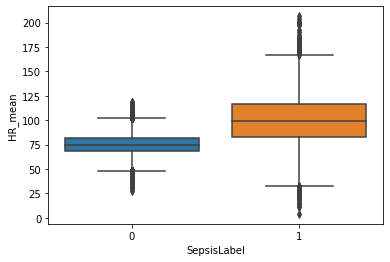

In [0]:
ax = sns.boxplot(x="SepsisLabel", y='HR_mean', data=train_df)

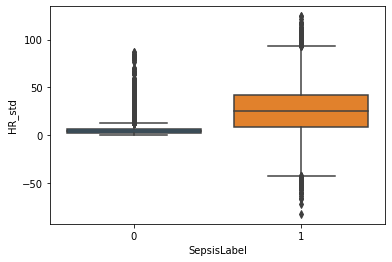

In [0]:
ax = sns.boxplot(x="SepsisLabel", y='HR_std', data=train_df)

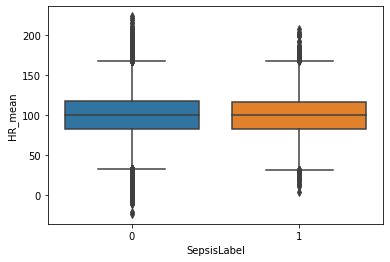

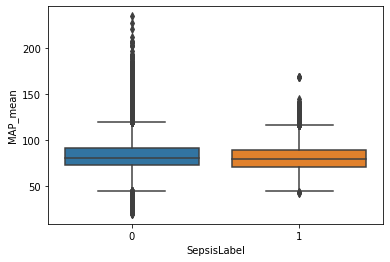

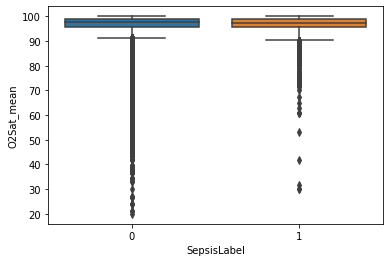

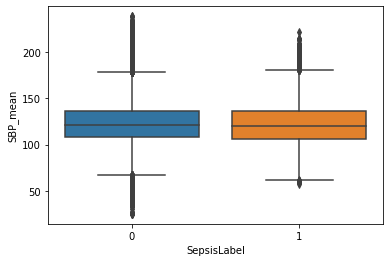

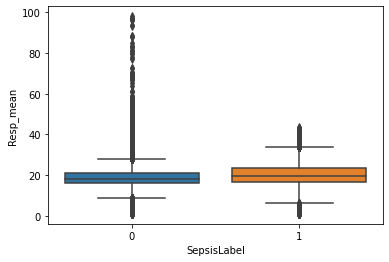

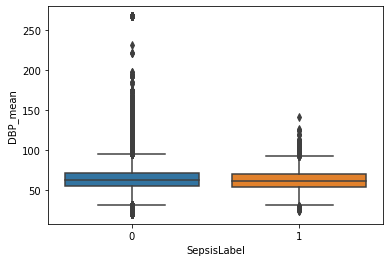

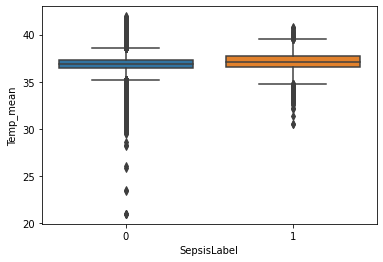

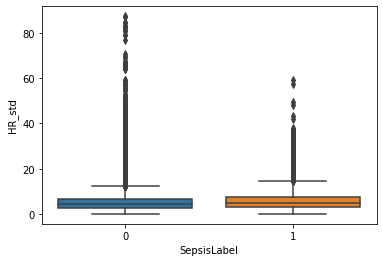

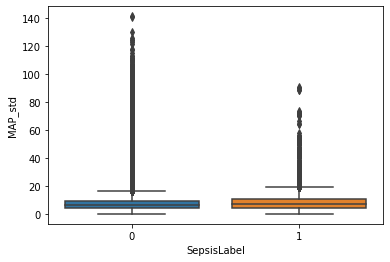

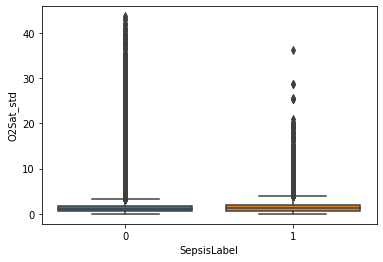

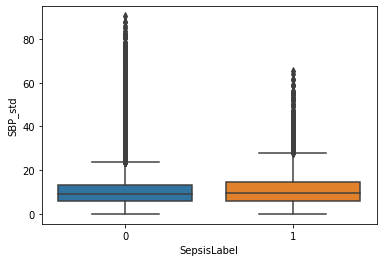

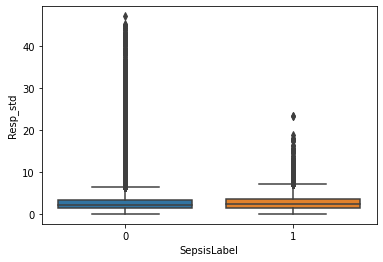

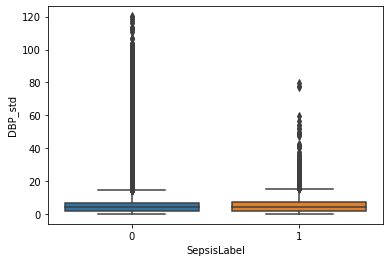

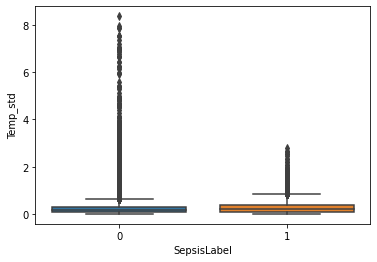

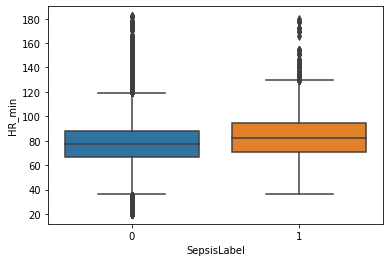

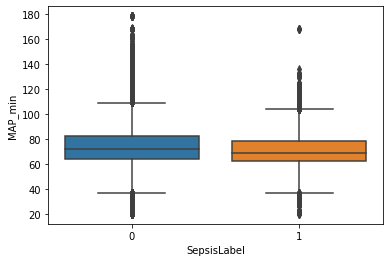

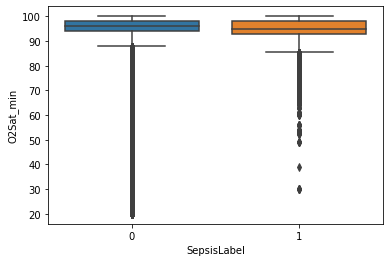

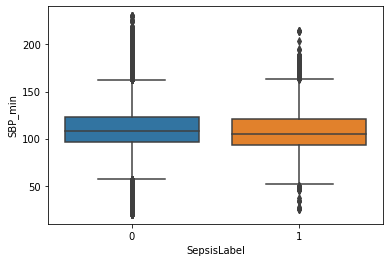

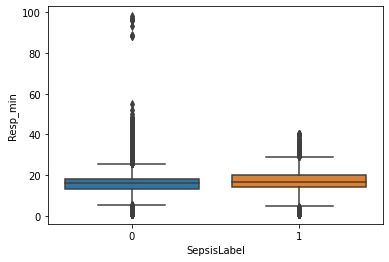

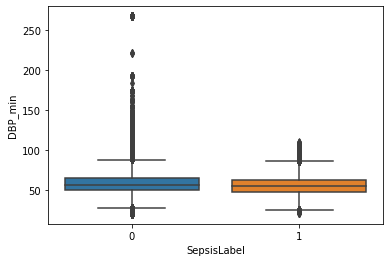

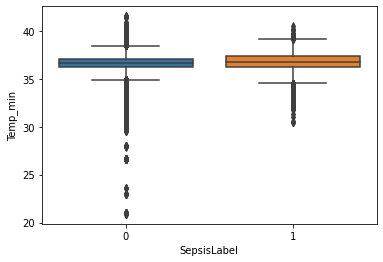

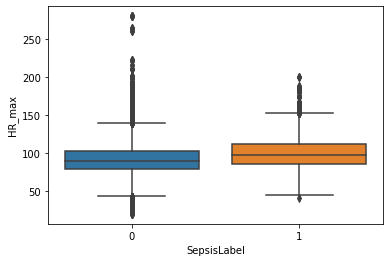

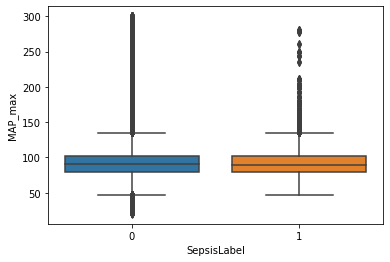

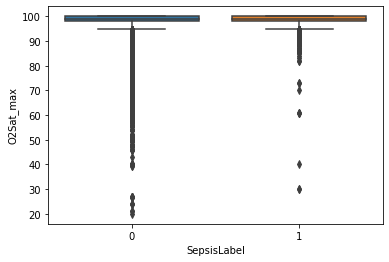

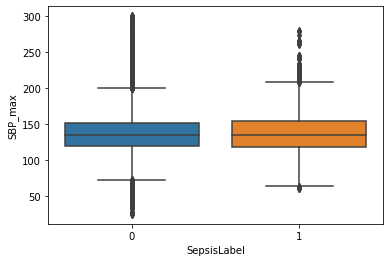

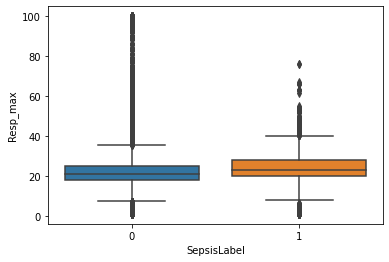

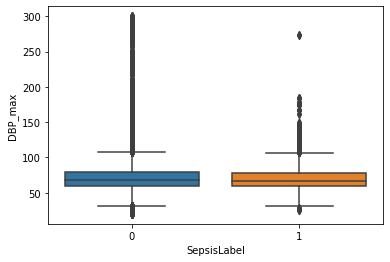

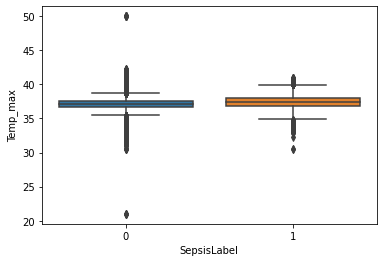

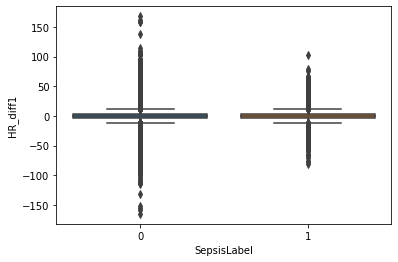

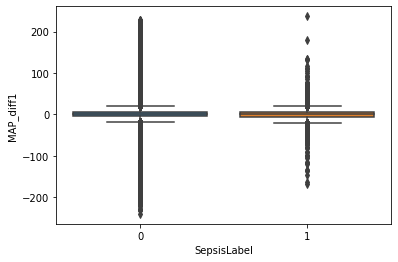

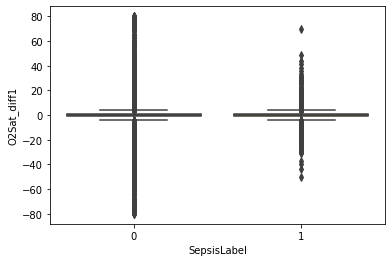

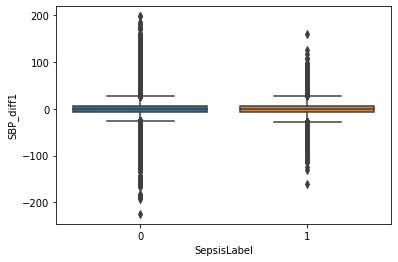

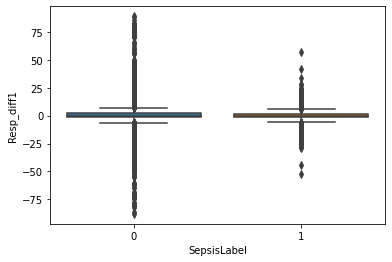

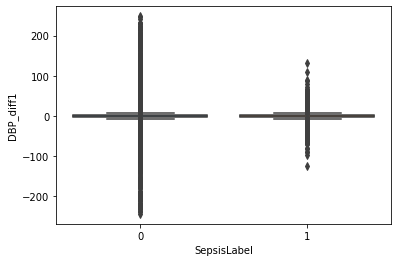

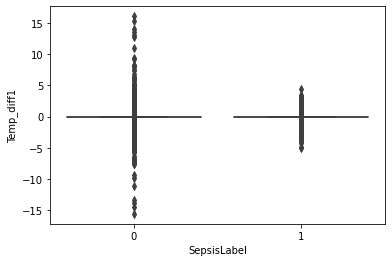

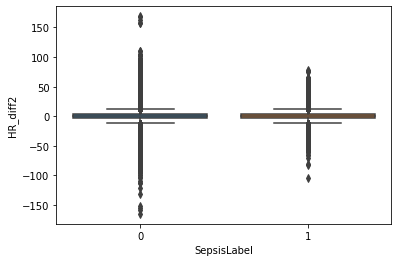

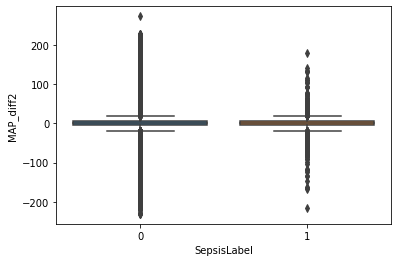

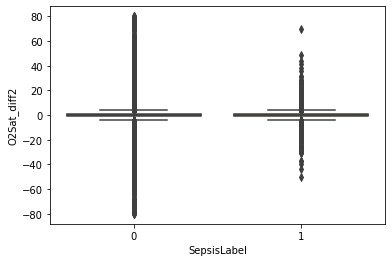

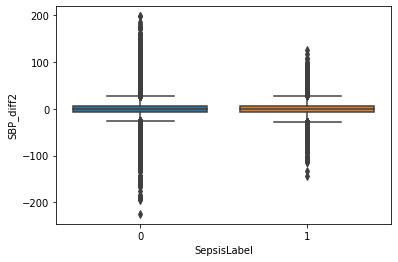

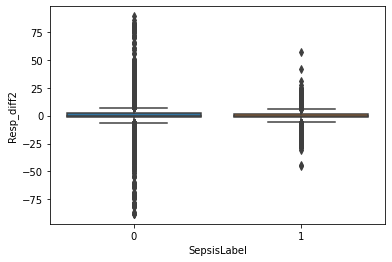

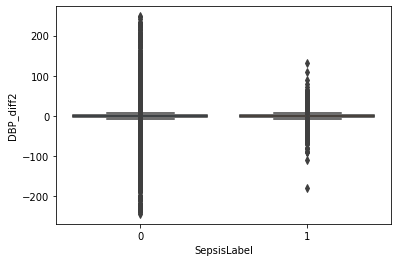

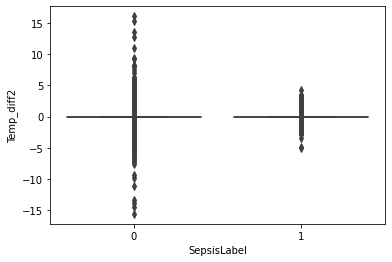

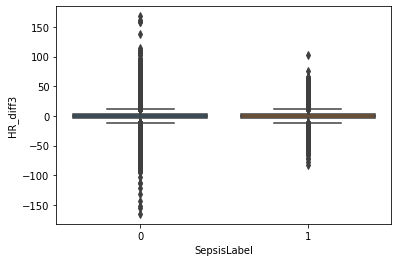

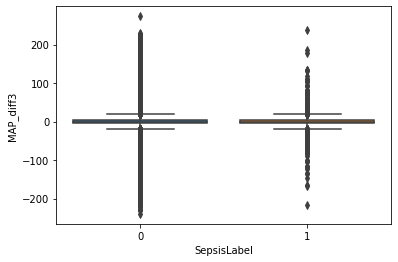

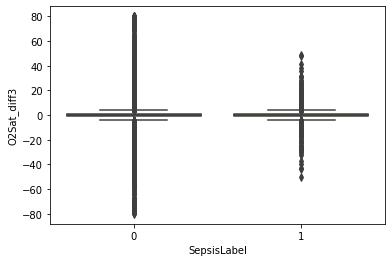

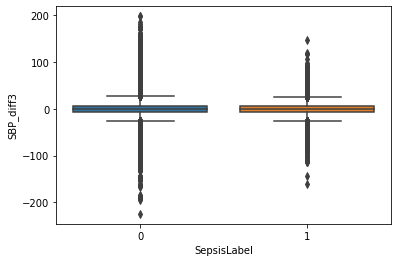

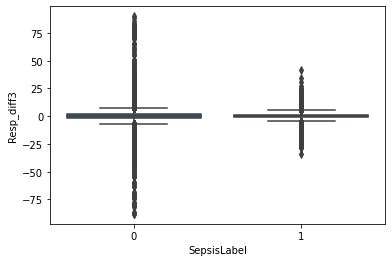

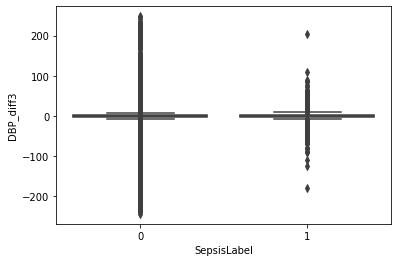

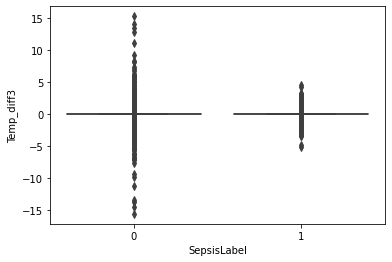

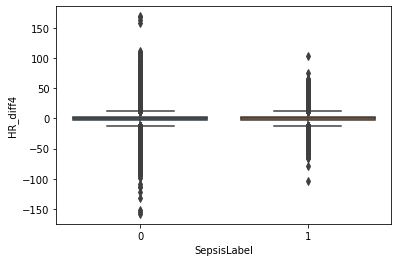

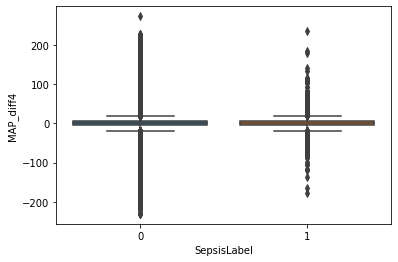

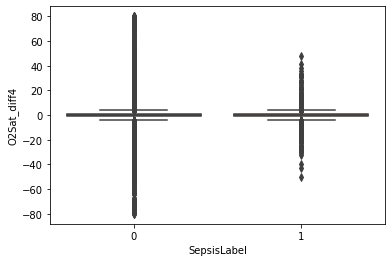

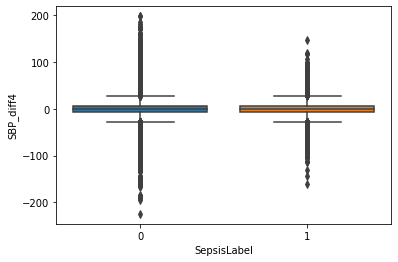

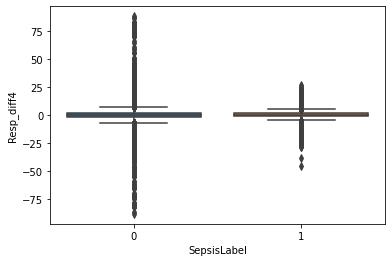

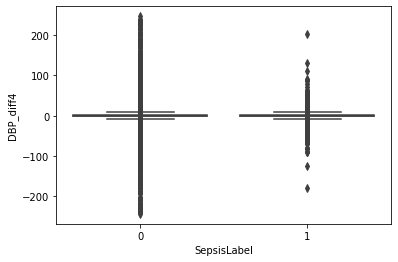

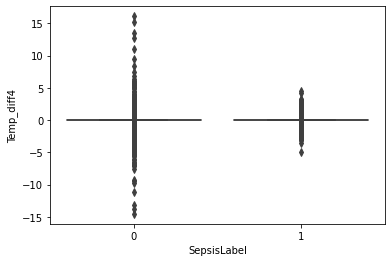

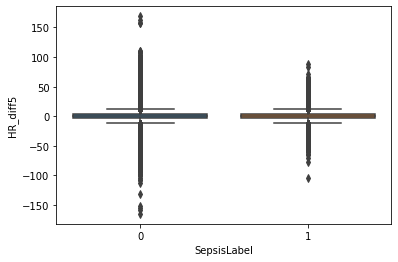

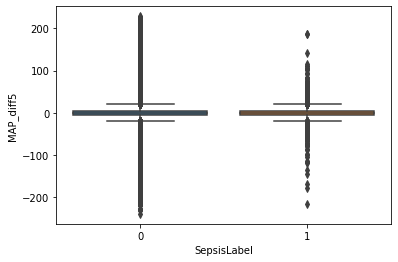

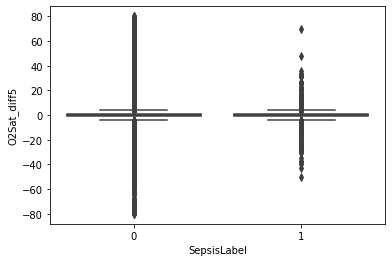

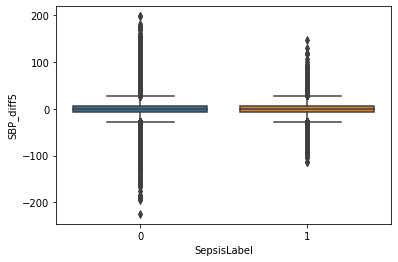

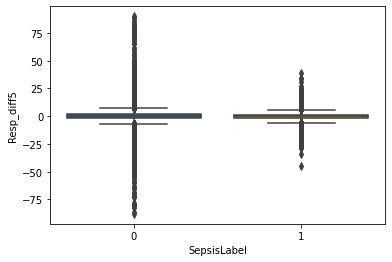

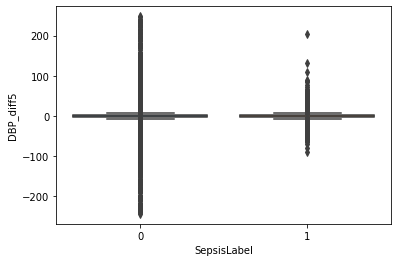

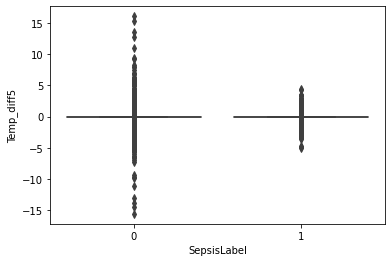

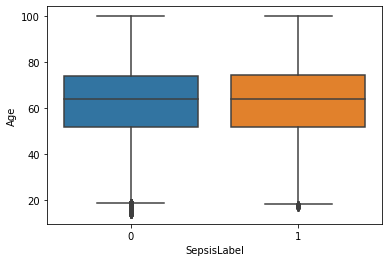

In [0]:
for i, var in enumerate(cont_vars):
  plt.figure(i)
  ax = sns.boxplot(x="SepsisLabel", y=var, data=train_df)

### Take a look at skewness of each variable

In [0]:
cat_vars = ['Gender']
cont_vars = [col for col in train_df.columns if col not in ['Gender', 'SepsisLabel']]

In [8]:
print('Total number of variables in training set: ', len(train_df.columns))
print('Number of categorical variables in training set: ', len(cat_vars))
print('Number of continuous variables in training set: ', len(cont_vars))

Total number of variables in training set:  68
Number of categorical variables in training set:  1
Number of continuous variables in training set:  66


In [0]:
skewness = pd.DataFrame()
skewness['Skew'] = train_df[cont_vars].skew(axis=0) # find skewness of each variable (along rows)
skewness = skewness.sort_values(by='Skew', ascending=True)

In [10]:
skewness

,Skew
HospAdmTime,-12.509456
O2Sat_min,-5.051313
O2Sat_max,-4.548473
O2Sat_mean,-3.935677
Temp_min,-0.666203
...,...
Temp_std,3.194027
DBP_std,3.452032
hour,4.185551
MAP_std,4.533054


### Yeo-Johnson transformation to un-skew variable distributions then Standardization (0 mean, 1 std)

In [0]:
scaler = PowerTransformer() # yeo-johnson transformation then standardization

In [12]:
scaler.fit(train_df[cont_vars]) # only fit on the continuous variables of train_df

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

In [0]:
train_clean = scaler.transform(train_df[cont_vars])

In [0]:
train_clean = pd.DataFrame(train_clean)

In [0]:
train_clean.columns = train_df[cont_vars].columns

In [16]:
train_clean.head()

,HR_mean,MAP_mean,O2Sat_mean,SBP_mean,Resp_mean,DBP_mean,Temp_mean,HR_std,MAP_std,O2Sat_std,SBP_std,Resp_std,DBP_std,Temp_std,HR_min,MAP_min,O2Sat_min,SBP_min,Resp_min,DBP_min,Temp_min,HR_max,MAP_max,O2Sat_max,SBP_max,Resp_max,DBP_max,Temp_max,HR_diff1,MAP_diff1,O2Sat_diff1,SBP_diff1,Resp_diff1,DBP_diff1,Temp_diff1,HR_diff2,MAP_diff2,O2Sat_diff2,SBP_diff2,Resp_diff2,DBP_diff2,Temp_diff2,HR_diff3,MAP_diff3,O2Sat_diff3,SBP_diff3,Resp_diff3,DBP_diff3,Temp_diff3,HR_diff4,MAP_diff4,O2Sat_diff4,SBP_diff4,Resp_diff4,DBP_diff4,Temp_diff4,HR_diff5,MAP_diff5,O2Sat_diff5,SBP_diff5,Resp_diff5,DBP_diff5,Temp_diff5,Age,hour,HospAdmTime
0,-0.494214,2.167066,-0.257952,2.350904,0.225659,-0.735066,0.030958,0.316975,0.998335,1.165242,-0.100423,0.582431,-1.565140,-0.887749,-0.398594,2.060733,-0.586981,2.428939,-0.136026,-0.218355,0.234737,-0.249107,1.984130,0.997467,2.025546,0.230224,-1.108712,-0.228386,-0.533278,2.248154,-1.621677,1.184451,-0.781000,-0.004030,-0.005838,0.810944,0.352274,0.011205,-0.698007,2.057526,-0.002085,-0.013301,-0.262749,-2.109323,1.669399,-1.033550,-1.041822,-0.000907,-0.020258,-1.758811,0.802503,0.013065,1.039101,-1.042822,0.001416,0.366599,1.469942,0.517552,0.820303,-0.533406,1.520423,0.001508,-0.019537,-1.860827,0.888277,0.860202
1,-0.193393,-0.087944,-0.962098,-1.177675,-0.403008,-0.735066,-0.292482,0.018641,-1.053614,0.590939,-0.426810,-0.161286,-1.565140,-1.014934,-0.136763,0.243862,-1.109181,-1.009552,-0.136026,-0.218355,-0.000762,-0.190966,-0.342644,-1.489824,-1.233596,-0.328424,-1.108712,-0.460255,-0.397834,-0.361590,0.009239,-0.220884,-1.298109,-0.004030,0.388014,0.006867,0.352274,0.011205,0.336162,0.767886,-0.002085,-0.013301,-0.262749,0.263557,0.010632,0.477899,0.251232,-0.000907,-0.020258,-0.941465,-0.088976,0.013065,0.408378,0.251263,0.001416,-0.022875,0.376658,0.257937,1.632739,-0.335923,-0.767137,0.001508,-0.019537,-0.893334,-1.390161,0.857733
2,-0.331641,-0.167874,1.098539,0.500142,-1.616478,-0.688061,0.370752,-1.002432,0.105426,-0.758338,0.375703,0.093771,-1.565140,-1.014934,-0.136763,-0.022197,1.306311,0.618126,-1.385239,-0.174296,0.656408,-0.608517,-0.187452,0.997467,0.444149,-1.148555,-1.064903,0.173521,0.141159,0.023172,-0.398517,0.055685,0.252445,-0.004030,0.388014,-0.263786,0.143171,0.422168,-0.082382,-0.522960,-0.002085,-0.013301,0.544869,-0.533440,0.010632,-0.830229,-0.394142,-0.000907,-0.020258,-0.669550,-0.795139,0.013065,-0.756775,0.898220,0.001416,-0.022875,0.008629,-0.001120,-0.399509,-0.005583,-1.530315,0.001508,-0.019537,-0.946406,-2.083610,0.860202
3,-0.887285,-1.591198,0.928442,0.305578,0.302074,-2.717441,0.782806,-1.305481,-0.609538,0.084334,0.019747,-1.168168,-0.215155,0.112553,-0.601098,-1.084504,0.431984,0.404318,0.807383,-2.370934,0.641137,-1.152291,-1.527181,0.997467,0.241785,-0.137486,-2.325307,0.711251,0.007078,-0.006292,0.009239,-0.013935,-0.005748,-0.004030,-0.005838,0.208647,-0.095141,1.244196,-1.139790,-0.006350,0.056790,-0.378487,0.142777,-0.357478,-0.811120,0.267431,0.251232,-0.352598,0.889165,0.007858,-0.000330,0.013065,-0.008627,-0.007534,0.001416,-0.022875,0.131755,-0.516446,-0.196052,-0.730605,-0.512788,-0.573754,0.829998,1.516115,-0.575000,-0.538956
4,-0.342376,-1.574415,-1.500226,-1.068332,0.677635,-1.110037,-0.124647,-0.632079,1.965759,0.687907,-0.854744,-0.472420,2.710147,0.379275,-0.136763,-2.525024,-1.331393,-0.606705,1.037155,-3.913921,-0.102561,-0.426486,-0.080115,-1.489824,-1.181838,0.407609,0.979952,-0.141851,0.408327,2.791573,0.824842,-0.358077,-0.005748,5.089426,-0.005838,-0.263786,0.802459,-1.221413,0.336162,-0.522960,1.534149,-0.013301,-0.127116,-0.621314,0.838336,-0.830229,0.765532,-0.819936,1.434558,0.142421,-0.442472,1.255211,0.758332,0.251263,-1.521870,-0.022875,-0.739896,-2.825594,-0.806550,-0.467615,-0.004206,-4.716430,-0.019537,1.743260,-1.587232,0.484262


In [0]:
# check the skewness of the variables after being cleaned
skew_clean = train_clean.skew(axis=0)

In [18]:
skewness['Skew_clean'] = skew_clean
skewness

,Skew,Skew_clean
HospAdmTime,-12.509456,5.801748
O2Sat_min,-5.051313,-0.075064
O2Sat_max,-4.548473,-0.364846
O2Sat_mean,-3.935677,-0.108350
Temp_min,-0.666203,0.077084
...,...,...
Temp_std,3.194027,0.158495
DBP_std,3.452032,-0.032735
hour,4.185551,-0.000081
MAP_std,4.533054,0.035178


### Calculate Variance Inflation Factor (VIF) for Multicollinearity

In [0]:
vif_df = pd.concat([train_clean, train_df['SepsisLabel']], axis=1)

In [0]:
#gather features
features = "+".join(cont_vars)

# get y and X dataframes based on this regression:
y_vif, X_vif = dmatrices('SepsisLabel ~' + features, vif_df, return_type='dataframe')

In [0]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif.loc[vif['VIF'] > 10, 'VIF'] = vif.loc[vif['VIF'] > 10]['VIF']/10
vif["features"] = X_vif.columns

In [0]:
vif = vif.sort_values(by=['VIF'])

In [0]:
vif = vif[vif['features'] != 'Intercept'] # drop the Intercept features
vif

,VIF,features
49,1.013489,Temp_diff3
66,1.037276,HospAdmTime
12,1.041049,Resp_std
65,1.055067,hour
10,1.103516,O2Sat_std
...,...,...
1,6.645173,HR_mean
8,7.031969,HR_std
24,7.946476,O2Sat_max
9,8.342779,MAP_std


In [0]:
vif.to_csv('6hour_vif.csv', index=False)

### Get the variables that have VIF < 10 

In [0]:
vif_features = vif[vif['VIF'] < 10]['features']

### Append the categorical variables to continuous variables after all the processing

In [0]:
X_all = pd.concat([train_clean[vif_features], train_df[cat_vars].reset_index(drop=True)], axis=1)
y_all = train_df['SepsisLabel'].reset_index(drop=True) # this is not necessary

In [0]:
X_all.drop(['HospAdmTime', 'hour'], axis=1, inplace=True)

In [0]:
print(X_all.shape)
print(y_all.shape)

(1080424, 64)
(1080424,)


### Save training sets

In [0]:
X_all.to_csv('6hour_Xtrain.csv', index=False)
y_all.to_csv('6hour_ytrain.csv', index=False)

### Process the test set as well

In [0]:
test_clean = scaler.transform(test_df[cont_vars])

In [0]:
test_clean = pd.DataFrame(test_clean)

In [0]:
test_clean.columns = test_df[cont_vars].columns

In [0]:
test_clean.head()

,HR_mean,MAP_mean,O2Sat_mean,SBP_mean,Resp_mean,DBP_mean,Temp_mean,HR_std,MAP_std,O2Sat_std,SBP_std,Resp_std,DBP_std,Temp_std,HR_min,MAP_min,O2Sat_min,SBP_min,Resp_min,DBP_min,Temp_min,HR_max,MAP_max,O2Sat_max,SBP_max,Resp_max,DBP_max,Temp_max,HR_diff1,MAP_diff1,O2Sat_diff1,SBP_diff1,Resp_diff1,DBP_diff1,Temp_diff1,HR_diff2,MAP_diff2,O2Sat_diff2,SBP_diff2,Resp_diff2,DBP_diff2,Temp_diff2,HR_diff3,MAP_diff3,O2Sat_diff3,SBP_diff3,Resp_diff3,DBP_diff3,Temp_diff3,HR_diff4,MAP_diff4,O2Sat_diff4,SBP_diff4,Resp_diff4,DBP_diff4,Temp_diff4,HR_diff5,MAP_diff5,O2Sat_diff5,SBP_diff5,Resp_diff5,DBP_diff5,Temp_diff5,Age,hour,HospAdmTime
0,-0.267536,-1.353010,0.358448,-1.319677,1.969656,-0.656954,0.479264,-1.491403,-0.328571,-0.379434,-0.835696,0.593528,0.562207,-1.554126,0.053913,-1.259238,0.431984,-0.833943,1.264778,-1.185566,0.794561,-0.547305,-1.303655,-0.007814,-1.418209,1.239603,-0.383509,0.144975,0.007078,-0.184228,0.009239,0.020831,-0.134899,0.113552,-0.005838,-0.263786,-0.006146,0.011205,-0.013278,-0.006350,-0.002085,-0.013301,0.142777,0.712025,-0.400842,-0.285928,-0.006476,1.182097,-0.020258,-0.262503,-1.367292,0.841352,-0.519785,-0.007534,-2.223344,-0.022875,0.254372,0.387699,-0.806550,0.160927,2.028475,0.461618,-0.019537,0.311133,0.720210,-0.697744
1,-0.549162,0.353466,1.098539,0.526904,-0.203064,-0.355556,0.985754,0.502647,1.807713,0.190728,2.106406,0.407428,1.204729,-0.942220,-0.601098,-0.998816,0.431984,-0.921173,-0.136026,-1.292729,1.264425,-0.486632,0.810559,0.997467,1.015449,0.048622,-0.030135,0.711251,-1.212289,-3.092115,0.009239,-3.340661,0.510542,-2.454130,-0.005838,1.211215,4.063779,0.422168,4.850362,1.283815,2.955765,-0.013301,0.277040,-3.330180,0.838336,-4.095719,-0.006476,-2.450271,-0.384200,-1.895210,0.445102,-1.231485,0.828468,-0.783991,0.001416,-0.022875,0.254372,0.171497,0.007343,0.127565,0.504125,0.116542,0.319698,1.298358,0.387978,-0.452914
2,0.187561,-0.463994,1.215654,0.281818,0.566070,-0.028916,-0.279969,-0.174692,0.148208,-0.703727,-0.587974,0.953423,-1.565140,-0.245408,0.301120,-0.666526,1.306311,0.380155,0.103801,0.446826,-0.160398,0.148182,-0.411288,0.997467,-0.009861,0.916955,-0.458039,-0.228386,-0.668867,0.532091,0.009239,0.477011,1.284521,-0.004030,-0.399066,0.409769,-0.095141,0.422168,0.125983,-2.849471,-0.002085,-0.013301,-1.217009,0.353087,0.010632,-0.285928,0.765532,-0.000907,-0.020258,1.079200,0.355857,-0.401567,-0.077296,1.545151,0.001416,-0.022875,-0.364382,0.604161,0.413917,0.931433,-0.512788,0.001508,-0.931476,0.676934,0.179484,0.860202
3,0.527518,0.370542,-0.176693,-1.350533,-1.024517,1.211973,-0.674506,0.943133,0.558421,0.564615,0.038937,-0.143770,1.008842,-0.942220,0.240041,0.027129,-0.281732,-1.630824,-0.874366,0.751211,-0.389332,0.628638,0.337885,0.997467,-1.285786,-1.148555,1.183986,-0.869953,-0.397834,-1.685421,0.009239,-1.854353,-0.005748,-1.988490,-0.005838,-1.080299,0.982886,0.011205,0.899896,-1.039789,1.179102,-0.013301,2.806842,-1.322629,0.010632,-0.626548,-0.006476,-1.868644,-0.020258,-2.577762,1.160379,-1.231485,0.478254,-0.007534,1.655950,-0.377003,1.772270,-0.902012,2.038839,-0.270010,0.504125,-1.436742,-0.019537,0.720035,-1.814944,-1.115165
4,0.992505,-0.856151,0.556345,-1.167655,3.724331,-0.688061,-0.142198,-0.791380,-0.229432,0.360786,-0.147111,0.877986,0.098815,-0.903632,1.220562,-0.830638,0.056844,-1.189896,3.862281,-0.777385,0.072410,0.731242,-0.929936,0.997467,-1.130507,2.960187,-0.611312,-0.300671,0.541609,-0.803774,0.009239,-1.108170,2.058215,-0.822818,-0.220402,-0.807671,0.622209,1.244196,0.406420,-0.006350,0.706054,-0.013301,0.411049,-0.004104,-1.629547,0.407662,-2.080150,-0.000907,-0.020258,0.410722,0.713101,0.427332,0.758332,1.803919,0.709481,-0.022875,-0.239650,-1.201617,0.413917,-1.189984,-1.021512,-1.149072,-0.391738,-0.487925,-1.062397,-0.895328


In [0]:
X_test = pd.concat([test_clean[vif_features], test_df[cat_vars].reset_index(drop=True)], axis=1)

In [0]:
y_test = test_df['SepsisLabel'].reset_index(drop=True)

In [0]:
X_test.drop(['HospAdmTime', 'hour'], axis=1, inplace=True)

In [0]:
print(X_test.shape)
print(y_test.shape)

(270106, 64)
(270106,)


### Save test sets

In [0]:
X_test.to_csv('6hour_Xtest.csv', index=False)
y_test.to_csv('6hour_ytest.csv', index=False)